# Example of Preset Hypothesis with SI4ONNX
## Import and Environment Setup

In [1]:
import os
import onnx
import si4onnx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# set seed
torch.manual_seed(0)

# set number of threads to 1
torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Buliding a Model with Pytorch
In this notebook, we will create a VAE.

In [2]:
device = torch.device("cpu")

class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, img_size):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten(),
        )

        # Calculate the size of the encoder output
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, img_size, img_size)
            encoder_output_size = self.encoder(dummy_input).shape[1]

        # Latent space
        self.fc_mu = nn.Linear(encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(encoder_output_size, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, encoder_output_size)

        self.decoder_reshape_size = (32, img_size // 4, img_size // 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                16, 8, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, in_channels, kernel_size=3, stride=1, padding=1),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, *self.decoder_reshape_size)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train_step(model, x, optimizer):
    model.train()
    optimizer.zero_grad()
    recon_x, mu, logvar = model(x)
    loss = vae_loss(recon_x, x, mu, logvar)
    loss.backward()
    optimizer.step()
    return loss.item()


# train VAE
shape=(1, 16, 16)
n_samples=200
batch_size=16
epochs=16

dataset = si4onnx.data.SyntheticDataset(n_samples=n_samples, shape=shape, seed=42)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(in_channels=1, latent_dim=16, img_size=shape[-1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    total_loss = 0
    for images, _, _ in train_loader:
        images = images.to(device)
        loss = train_step(model, images, optimizer)
        total_loss += loss

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/16], Loss: 3974.9041
Epoch [2/16], Loss: 3958.5926
Epoch [3/16], Loss: 3955.4527
Epoch [4/16], Loss: 3954.0861
Epoch [5/16], Loss: 3956.2637
Epoch [6/16], Loss: 3956.1935
Epoch [7/16], Loss: 3955.1672
Epoch [8/16], Loss: 3954.9629
Epoch [9/16], Loss: 3954.7577
Epoch [10/16], Loss: 3952.4784
Epoch [11/16], Loss: 3953.3688
Epoch [12/16], Loss: 3953.2159
Epoch [13/16], Loss: 3954.2822
Epoch [14/16], Loss: 3952.8706
Epoch [15/16], Loss: 3952.8508
Epoch [16/16], Loss: 3954.3623


## Save the model as ONNX
We will save the model as ONNX format. Please note the model is `.eval()` mode.

In [3]:
# export onnx
model.eval()
dummy_input = torch.randn(1, *shape).to(device)
model_path = "./models/vae.onnx"
torch.onnx.export(model, dummy_input, model_path)

## Load ONNX model to SI4ONNX
1. Construct a model by wrapping the abstract class `si.SI4ONNX`.
1. Implement the `construct_hypothesis` method to calculate the observed ROI $\mathcal{M}_{X^{\mathrm{obs}}}$ and compute the test statistics.
1. The `algorithm` method calculates the interval and the ROI $\mathcal{M}_{X}$.
1. The `model_selector` compares the ROI $\mathcal{M}_{X^{\mathrm{obs}}}$ with the $\mathcal{M}_{X}$ obtained by Parametric Programming to determine whether they match.

### Preset Hypotheses
si4onnx provides the following hypothesis tests presets:
- `BackMeanDiff`  
BackgroundMeanDiff is a hypothesis test that compares the mean of the ROI $\mathcal{M}_{X^{\mathrm{obs}}}$ with the mean of the other region.

- `NeighborMeanDiff`  
NeighborhoodMeanDiff is a hypothesis test that compares the mean of the ROI $\mathcal{M}_{X^{\mathrm{obs}}}$ with the mean of its neighborhood region.
Users can set the neighborhood range using the `neighborhood_range` option.

- `ReferenceMeanDiff`  
ReferenceMeanDiff is a hypothesis test that compares the mean of the ROI $\mathcal{M}_{X^{\mathrm{obs}}}$ with the mean of the same region in a reference image.
Users can specify the reference image using the reference_image option.

Those hypothesis tests have the argument `post_process` to specify the post-processing method.
The post-processing operation can be selected from the following examples:
- `Abs`: Absolute value 
- `InputDiff`: Difference from the output image and input image 
- `AverageFilter`: Average filter 
- `GaussianFilter`: Gaussian filter 

For example of VAE, the post-processing method is `InputDiff` -> `Abs` -> `AverageFilter` to obtain the filtered reconstruction error.

The following is an example of using the `BackMeanDiff` hypothesis test.

In [4]:
from si4onnx.hypothesis import BackMeanDiff, NeighborMeanDiff, ReferenceMeanDiff
from si4onnx.operators import InputDiff, Abs, AverageFilter

# load onnx model
onnx_model = onnx.load(model_path)

# load si model
si_model = si4onnx.load(
    model=onnx_model, 
    hypothesis=BackMeanDiff(
        threshold=0.9,
        post_process=[InputDiff(), Abs(), AverageFilter()],
    ),
) 

For testing, we create a dataset that follows a standard normal distribution $\mathcal{N}(0, I)$.
The si4onnx provides the `SyntheticDataset` class to create a dataset.

In [5]:
test_data = si4onnx.data.SyntheticDataset(n_samples=1000, shape=shape, seed=0)
test_loader = DataLoader(test_data, batch_size=1)

### Selective $p$-value calculation

The `inferenece` method calculates the selective $p$-value.
The selective $p$-value can be obtained by calling the `p_value` attribute of the result.
The inference_mode option can be set to `parametric` or `over_conditioning` to calculate the selective $p$-value.
Default is `parametric`.
Also, if you set `n_jobs`, you can perform parallel computation.

```python
result = si_model.inference(input_x, var=1.0, inference_mode="parametric", n_jobs=8)
```

In [6]:
# inference
input_x = next(iter(test_loader))[0]
result = si_model.inference(input_x, var=1.0)

print('selective p-value:', result.p_value)

selective p-value: 0.353541117947475


### Naive $p$-value calculation
The `naive_p_value()` method calculates the naive $p$-value.
The naive $p$-value have bias by double-dipping, so it is invalid.

In [7]:
print("naive p-value:", result.naive_p_value())

naive p-value: 0.1605240593465032


The following is an example of `NeighborMeanDiff` hypothesis test.

In [8]:
si_model = si4onnx.load(
    model=onnx_model, 
    hypothesis=NeighborMeanDiff(
        threshold=0.95,
        post_process=[InputDiff(), Abs(), AverageFilter()],
        use_norm=True,
    ),
)

result = si_model.inference(input_x, var=1.0)
print('selective p-value:', result.p_value)

selective p-value: 0.7703587928864365


The following is an example of `ReferenceMeanDiff` hypothesis test.
Note the method `inference` have a input as tuple of input image and reference image `(x, ref_x)`.

In [9]:
rng = np.random.default_rng(0)
ref_x = rng.random(input_x.shape)

si_model = si4onnx.load(
    model=onnx_model,
    hypothesis=ReferenceMeanDiff(
        threshold=0.95,
        post_process=[InputDiff(), Abs(), AverageFilter()],
        use_norm=True,
    ),
)

result = si_model.inference((input_x, ref_x), var=1.0)
print('selective p-value:', result.p_value)

selective p-value: 0.6509188409745303


## Check the uniformity of $p$-values
When the input data follows the null hypothesis, the $p$-value is uniformly distributed.

In [10]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count

si_model = si4onnx.load(
    model=onnx_model, 
    hypothesis=BackMeanDiff(
        threshold=1.0,
        post_process=[InputDiff(), Abs(), AverageFilter()],
    ),
) 

with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
    futures = [executor.submit(si_model.inference, x, 1.0) for x, _, _ in test_loader]
    results = [f.result() for f in tqdm(as_completed(futures), total=len(test_loader))]

100%|██████████| 1000/1000 [00:15<00:00, 64.29it/s]


### Results
Selective $p$-value have uniformity in the null hypothesis, but naive $p$-value have bias by double-dipping.

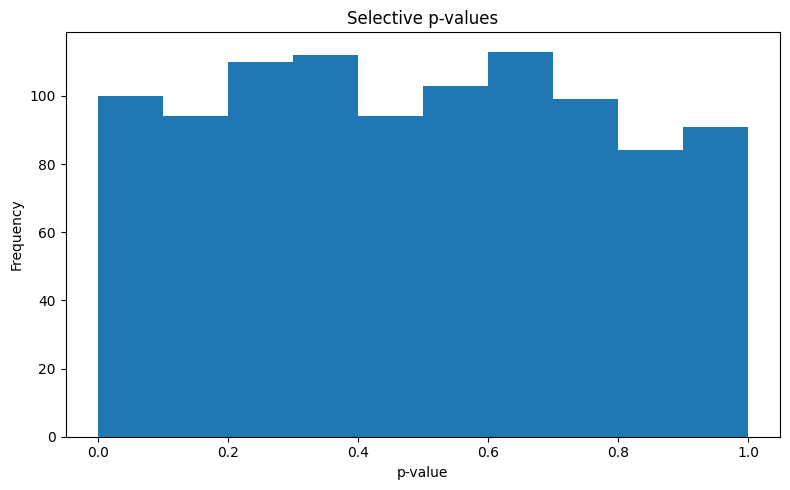

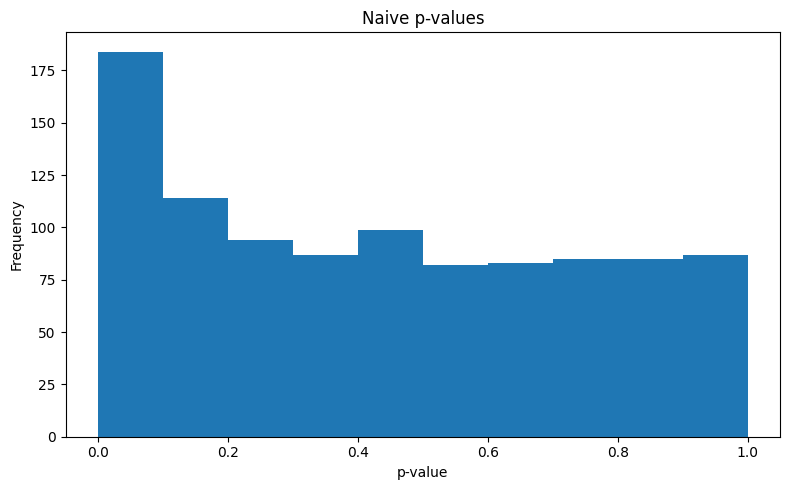

In [11]:
import matplotlib.pyplot as plt

selective_p_values = [result.p_value for result in results]
naive_p_values = [result.naive_p_value() for result in results]
plt.figure(figsize=(8, 5))
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Selective p-values')
plt.hist(selective_p_values)
plt.show()
plt.close()

plt.figure(figsize=(8, 5))
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Naive p-values')
plt.hist(naive_p_values)
plt.show()
plt.close()